## 꽃 이미지 분류 (이진 분류 방식)

이 노트북은 데이지(daisy)와 민들레(dandelion) 이미지를 분류하는 딥러닝 모델을 **이진 분류(Binary Classification)** 방식으로 구축합니다. 이전의 다중 분류 접근법(`softmax`, `sparse_categorical_crossentropy`)과 달리, 여기서는 `sigmoid` 활성화 함수와 `binary_crossentropy` 손실 함수를 사용합니다.

**주요 차이점:**
- **출력층**: `Dense(1, activation='sigmoid')`를 사용하여 하나의 뉴런이 '클래스 1일 확률'을 직접 출력하도록 합니다.
- **손실 함수**: `binary_crossentropy`를 사용하여 이진 분류 문제에 최적화된 손실을 계산합니다.

### 1. 라이브러리 임포트 및 기본 설정

In [1]:
import numpy as np
import os
import PIL.Image as pilimg
import imghdr
import tensorflow as tf
from keras import models, layers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob

# 기본 경로 설정
base_path = "../../data/flowers2"

C:\Users\Admin\AppData\Local\Temp\ipykernel_22296\4090189009.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


### 2. 데이터 준비: 이미지 파일을 NumPy 배열로 변환

모든 이미지를 일정한 크기(80x80)로 조정하고 NumPy 배열로 변환하여 `.npz` 파일로 저장합니다. 이 과정은 한 번만 실행하면 되며, 이 노트북의 다른 버전(`꽃분류2.ipynb`)에서 이미 실행했다면 건너뛸 수 있습니다.

In [2]:
def make_data_from_images(flower_name, label, is_train=True):
    """특정 꽃 이미지를 읽어 npz 파일로 저장합니다."""
    path_type = "train" if is_train else "test"
    path = os.path.join(base_path, path_type, flower_name)
    data = []
    labels = []
    
    print(f"'{flower_name}' ({path_type}) 카테고리 처리 시작...")
    if not os.path.exists(path):
        print(f"  경로를 찾을 수 없습니다: {path}")
        return
        
    filenames = os.listdir(path)
    for i, filename in enumerate(filenames):
        if (i + 1) % 100 == 0:
            print(f"  {i + 1} / {len(filenames)} 번째 파일 처리 중...")
        
        file_path = os.path.join(path, filename)
        try:
            if imghdr.what(file_path) in ["gif", "png", "jpeg", "jpg"]:
                img = pilimg.open(file_path)
                resize_img = img.resize((80, 80))
                pixel = np.array(resize_img)
                if pixel.shape == (80, 80, 3):
                    data.append(pixel)
                    labels.append(label)
        except Exception as e:
            print(f"  파일 처리 오류: {filename}, 오류: {e}")

    save_filename = f"imagedata_{label}_{path_type}.npz"
    np.savez(save_filename, data=data, targets=labels)
    print(f"'{flower_name}' ({path_type}) 데이터 저장 완료 -> {save_filename}")

def initialize_dataset():
    """모든 카테고리에 대해 데이터 생성을 수행합니다."""
    if len(glob.glob('imagedata_*.npz')) >= 4:
        print("이미 전처리된 .npz 파일들이 존재합니다. 데이터 생성을 건너뜁니다.")
        return

    flowers = ["daisy", "dandelion"] # 0: daisy, 1: dandelion
    for i, f in enumerate(flowers):
        make_data_from_images(f, i, is_train=True)
        make_data_from_images(f, i, is_train=False)
    print("\n모든 데이터 저장 완료.")

# 데이터 준비 함수 실행
initialize_dataset()

이미 전처리된 .npz 파일들이 존재합니다. 데이터 생성을 건너뜁니다.


### 3. 데이터 로딩 및 전처리
생성된 `.npz` 파일들을 불러와 훈련 및 테스트 데이터셋을 구성하고, DNN 모델에 맞게 전처리합니다.

In [3]:
def load_and_preprocess_data():
    """npz 파일들을 로드하고 전처리하여 최종 데이터셋을 반환합니다."""
    with np.load("imagedata_0_train.npz") as f1, np.load("imagedata_1_train.npz") as f2:
        X_train = np.concatenate((f1["data"], f2["data"]), axis=0)
        y_train = np.concatenate((f1["targets"], f2["targets"]), axis=0)

    with np.load("imagedata_0_test.npz") as f1, np.load("imagedata_1_test.npz") as f2:
        X_test = np.concatenate((f1["data"], f2["data"]), axis=0)
        y_test = np.concatenate((f1["targets"], f2["targets"]), axis=0)
        
    X_train_flat = X_train.reshape(X_train.shape[0], 80 * 80 * 3)
    X_test_flat = X_test.reshape(X_test.shape[0], 80 * 80 * 3)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_test_scaled = scaler.transform(X_test_flat)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

X_train, y_train, X_test, y_test = load_and_preprocess_data()

print("--- 최종 데이터 형태 ---")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

--- 최종 데이터 형태 ---
X_train shape: (1275, 19200)
y_train shape: (1275,)


### 4. 모델 구축 (이진 분류 방식)
이진 분류를 위한 DNN 모델을 정의합니다. 출력층에 `Dense(1, activation='sigmoid')`를 사용하여 '민들레(클래스 1)일 확률'을 0과 1 사이의 값으로 출력합니다. 손실 함수로는 `binary_crossentropy`를 사용합니다.

In [4]:
def create_binary_model():
    network = models.Sequential([
        layers.Input(shape=(80 * 80 * 3,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid") # 이진 분류를 위한 출력층
    ])

    network.compile(optimizer='rmsprop',
                    loss='binary_crossentropy', # 이진 분류를 위한 손실 함수
                    metrics=['accuracy'])
    return network

model = create_binary_model()
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2457728   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2472257 (9.43 MB)
Trainable params: 2472257 (9.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 5. 모델 훈련
전처리된 데이터를 사용하여 모델을 학습시킵니다.

In [5]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=100,
                    validation_data=(X_test, y_test))

Epoch 1/100


13/13 [==============================] - 1s 39ms/step - loss: 1.2460 - accuracy: 0.5710 - val_loss: 0.9671 - val_accuracy: 0.5165
Epoch 2/100
13/13 [==============================] - 0s 26ms/step - loss: 0.8080 - accuracy: 0.6376 - val_loss: 0.8996 - val_accuracy: 0.6044
Epoch 3/100
13/13 [==============================] - 0s 27ms/step - loss: 0.7039 - accuracy: 0.7067 - val_loss: 0.7658 - val_accuracy: 0.6264
Epoch 4/100
13/13 [==============================] - 0s 26ms/step - loss: 0.6345 - accuracy: 0.7365 - val_loss: 0.7874 - val_accuracy: 0.5714
Epoch 5/100
13/13 [==============================] - 0s 26ms/step - loss: 0.4749 - accuracy: 0.7976 - val_loss: 0.7793 - val_accuracy: 0.6264
Epoch 6/100
13/13 [==============================] - 0s 26ms/step - loss: 0.5066 - accuracy: 0.8133 - val_loss: 0.7390 - val_accuracy: 0.5824
Epoch 7/100
13/13 [==============================] - 0s 25ms/step - loss: 0.4515 - accuracy: 0.8220 - val_loss: 0.7506 - val_accuracy: 0.6374
Epoc

### 6. 모델 평가 및 결과 시각화
훈련된 모델의 최종 성능을 평가하고, 훈련 과정 동안의 손실과 정확도 변화를 그래프로 시각화합니다.


--- 최종 모델 평가 ---
훈련셋   => 손실값: 0.0000, 정확도: 1.0000
테스트셋 => 손실값: 3.9389, 정확도: 0.6319


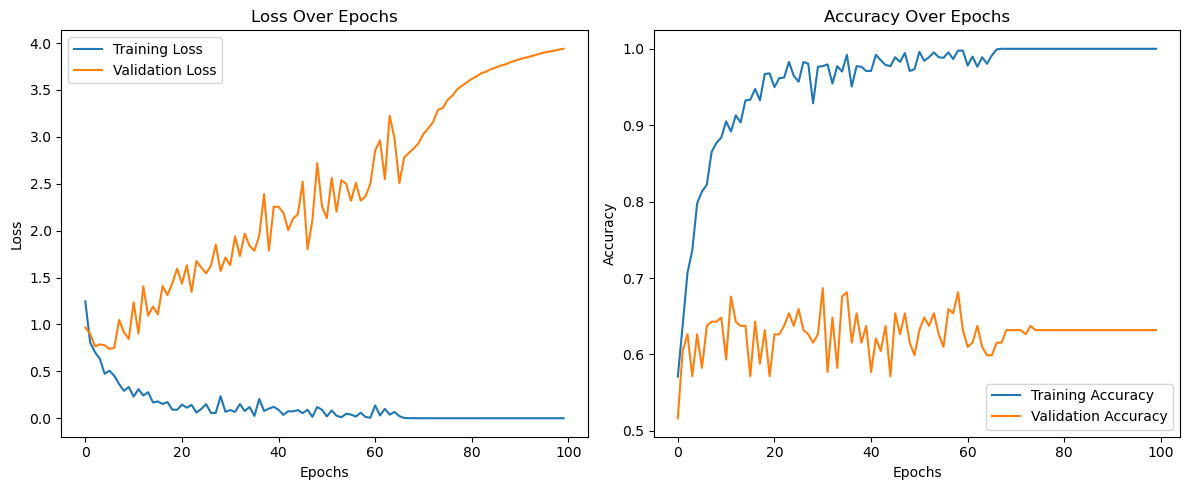

In [6]:
print("\n--- 최종 모델 평가 ---")
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"훈련셋   => 손실값: {train_loss:.4f}, 정확도: {train_acc:.4f}")
print(f"테스트셋 => 손실값: {test_loss:.4f}, 정확도: {test_acc:.4f}")

# 훈련 과정 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()